In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [3]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
        dict_path = 'D:\CIS-PD Study\Data_dict'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        results_path = r'C:\Users\andre\Documents\GitHub\CIS_PD\Results' #results folder
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'
        results_path = r'C:\Users\adai\Documents\GitHub\CIS_PD\Results'
    
else:
    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
    folder_path = '/Volumes/RTO/CIS-PD Study/'
    dict_path = '../Data_dict' # Mac local path
    scores_path = '../Scores/' # Mac local path
    features_path = '../FeatureMatrix' # Mac local path
    results_path = '../Results' # Mac local path

# Run if Need to Generate Unpacked Metafeatures

### Start metadata extraction

In [10]:
# Data = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_HP+LP_GyroLP.h5')) #bradykinesia
Data = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_HP.h5')) #tremor
# Data = pd.read_hdf(os.path.join(features_path,'Features_Hands_Unfiltered.h5'))
# Data = pd.read_hdf(os.path.join(features_path,'Features_Hands_HP.h5'))

#use only hand sensors
# Data=Data.drop(['distal_lateral_shank__accel','distal_lateral_shank__gyro','flexor_digitorum__accel','medial_chest_accel','anterior_thigh__accel','anterior_thigh__gyro','sacrum_gyro','sacrum_accel'],axis=1)

# print(Data.shape)
# Data.head(2)

# namesuffix = 'HP+LP_GyroLP.pkl'
# namesuffix='BP.pkl'
namesuffix='HP.pkl'
# namesuffix='Hands_Unfiltered.pkl'
# datafile = 'DataRaw_AllLocs_'+namesuffix
# featfile = 'Features_AllLocs_'+namesuffix
# output = 'MetaFeatures_'+namesuffix

# Data = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_HP.h5'))
# Data = Data.reset_index(drop=True)
# print(Data.shape)
# metadata = pickle.load(open(os.path.join(features_path,datafile),'rb'))
# metadata=metadata.reset_index(drop=True)
# metadata = metadata.iloc[:,:7]
# print(metadata.shape)
# #concatenates metadata
# Data=pd.concat((metadata,Data),axis=1)
# print(Data.shape)
# #save features pkl file
# f = open(os.path.join(features_path,output),'wb')
# pickle.dump(Data,f)
# f.close()

#filter empty rows on all locations
for s in Data.columns.values[7:]:
    print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
    Data = Data[Data[s].apply(type) != float]

#filter empty rows (no features available) on hand sensors
print('discarded %d rows'%(len(Data[Data.dorsal_hand__accel.apply(type) == float])))
Data = Data[Data.dorsal_hand__accel.apply(type) != float]
print('discarded %d rows'%(len(Data[Data.dorsal_hand__gyro.apply(type) == float])))
Data = Data[Data.dorsal_hand__gyro.apply(type) != float]

#unpack features
colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
       'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
       'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

# sensor_list = ['anterior_thigh_','dorsal_hand_','sacrum'] #sensors used
sensor_list = ['dorsal_hand_'] #hands only


colnames1=[i+'acc' for i in colnames]
colnames2=[i+'gyr' for i in colnames]
colnames=colnames1+colnames2

Datafinal = pd.DataFrame()

for i in range(len(Data)):
    Datatemp=pd.DataFrame()
    for sensors in sensor_list:
        F1 = Data[sensors + '_accel'].iloc[i]
        F2 = Data[sensors + '_gyro'].iloc[i]
        F = pd.DataFrame(data=np.hstack((F1,F2)).reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames])
        Datatemp=pd.concat((Datatemp,F),axis=1)
    Datafinal = pd.concat((Datafinal,Datatemp),axis=0)

Datafinal=Datafinal.reset_index(drop=True)
# Datanew=Datanew.reset_index(drop=True)
Data=Data.reset_index(drop=True)
Data = pd.concat((Data.iloc[:,:7],Datafinal),axis=1)

f = open(os.path.join(features_path,'UnpackedMetaFeat_' + namesuffix),'wb')
pickle.dump(Data,f)
f.close()

anterior_thigh__accel,discarded 6051 rows
anterior_thigh__gyro,discarded 0 rows
distal_lateral_shank__accel,discarded 3 rows
distal_lateral_shank__gyro,discarded 0 rows
dorsal_hand__accel,discarded 3 rows
dorsal_hand__gyro,discarded 0 rows
flexor_digitorum__accel,discarded 331 rows
medial_chest_accel,discarded 9 rows
sacrum_accel,discarded 2 rows
sacrum_gyro,discarded 0 rows
discarded 0 rows
discarded 0 rows


In [11]:
Data.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008648,0.010949,0.007293,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008127,0.010331,0.007008,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007309,0.009999,0.005955,...,1497.256257,3.439717,10.691567,0.180830,8.709283,0.326298,0.498028,0.397453,0.464745,0.272388
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007892,0.011164,0.006744,...,363.558576,2.730515,8.055003,0.008782,9.664828,0.278852,0.153846,0.428002,0.655817,0.311471
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007895,0.010229,0.008627,...,691.178211,4.005442,15.305682,0.143234,12.232884,-0.080442,0.106834,0.402190,0.506060,0.386501


# Start Below

# Load unpacked features data

In [198]:
filename = 'UnpackedMetaFeat_HP+LP_GyroLP.pkl' #bradykinesia
# filename = 'UnpackedMetaFeat_HP.pkl' #tremor

symptom = 'Bradykinesia'
# symptom = 'Tremor'

In [199]:
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)
Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)
print(Dataorig.shape)

#drop features 
Data=Data.drop(labels=['RMSXacc_dorsal_hand_','RMSYacc_dorsal_hand_','RMSZacc_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc_dorsal_hand_','meanYacc_dorsal_hand_','meanZacc_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc_dorsal_hand_','varYacc_dorsal_hand_','varZacc_dorsal_hand_'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr_dorsal_hand_','RMSYgyr_dorsal_hand_','RMSZgyr_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr_dorsal_hand_','meanYgyr_dorsal_hand_','meanZgyr_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr_dorsal_hand_','varYgyr_dorsal_hand_','varZgyr_dorsal_hand_'],axis=1) #range is strongly correlated with variance

Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5
Dataorig = Data.copy()

visits = Data.Visit.unique()
visits[visits != '4 Weeks']

Dataorig = Data.copy()

#remove nan symptoms
Data=Data[~Data[symptom].isnull()]

#generate subject list
subjs=Data.Subject.unique()

(41572, 81)
(41572, 81)


In [200]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,rangeXacc_dorsal_hand_,rangeYacc_dorsal_hand_,rangeZacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.599504,0.744752,0.483158,...,385.995020,3.356436,13.163123,0.109848,7.518253,0.280635,-0.434568,0.364178,0.427683,0.352723
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.535280,0.693556,0.445568,...,605.040885,4.317019,17.782045,-0.186576,8.443760,0.374303,-0.674552,0.249201,0.253660,0.290202


# Global Models - Random Selection of Subjects

In [9]:
subjs=Data.Subject.unique()
tasks=Data.Task.unique()

#sample p subjects at random for train and test on remaining
# ntrain = [4,8,16]
# ntrain = [4,8,10,12,14,16]
ntrain = [4,5,6,7,8,9,10,11,12,13,14,15,16]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

#remove nan rows for current symptom
Data=Data[~Data[symptom].isnull()]

results={}
for ng in ntrain:
    auc_all=[]; subj=[]; tasks_all=[];
    t1=time.time()
    for iteration in range(500):
        trainsubj = np.random.choice(subjs,size=ng,replace=False) #sample subjects at random
        
        # select random test subject out of remaining subjs not trained on
#         testsubj = np.random.choice(np.setxor1d(subjs,trainsubj),size=1,replace=False)
        testsubj = np.setxor1d(subjs,trainsubj)
        
        dtrain = Data[Data.Subject.isin(trainsubj)]
        dtest = Data[Data.Subject.isin(testsubj)]
        Xtr = dtrain.iloc[:,7:].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)
        Xte = dtest.iloc[:,7:].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int)
        ytask = dtest[dtest[symptom]>0].Task
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        
        auc_all.append(auroc)
        subj.append(testsubj)
        tasks_all.append(ytask)
        
        if iteration%50==0:
            print('Subj=%s,Test=%s,Iter=%d, AUROC=%.3f'%(trainsubj,testsubj,iteration,auroc))

    results.update({ng:[auc_all,subj,tasks_all]}) #save auc for all runs for each group
    print('elapsed %.3f min'%((time.time()-t1)/60))

np.save(os.path.join(results_path,'brady_full_randomSubjs.npy'),results)

Subj=[1029 1056 1046 1019],Test=[1004 1016 1018 1024 1030 1032 1038 1044 1047 1049 1051 1052 1053 1054
 1055],Iter=0, AUROC=0.652
Subj=[1038 1004 1052 1053],Test=[1016 1018 1019 1024 1029 1030 1032 1044 1046 1047 1049 1051 1054 1055
 1056],Iter=50, AUROC=0.680
Subj=[1019 1053 1004 1018],Test=[1016 1024 1029 1030 1032 1038 1044 1046 1047 1049 1051 1052 1054 1055
 1056],Iter=100, AUROC=0.697
Subj=[1024 1038 1056 1047],Test=[1004 1016 1018 1019 1029 1030 1032 1044 1046 1049 1051 1052 1053 1054
 1055],Iter=150, AUROC=0.697
Subj=[1055 1056 1032 1024],Test=[1004 1016 1018 1019 1029 1030 1038 1044 1046 1047 1049 1051 1052 1053
 1054],Iter=200, AUROC=0.634
Subj=[1054 1053 1038 1055],Test=[1004 1016 1018 1019 1024 1029 1030 1032 1044 1046 1047 1049 1051 1052
 1056],Iter=250, AUROC=0.682
Subj=[1044 1016 1056 1053],Test=[1004 1018 1019 1024 1029 1030 1032 1038 1046 1047 1049 1051 1052 1054
 1055],Iter=300, AUROC=0.657
Subj=[1056 1029 1024 1038],Test=[1004 1016 1018 1019 1030 1032 1044 1046 1047 1

Subj=[1047 1055 1053 1019 1056 1049 1051 1038 1016 1030],Test=[1004 1018 1024 1029 1032 1044 1046 1052 1054],Iter=100, AUROC=0.729
Subj=[1046 1029 1016 1038 1004 1054 1032 1030 1047 1051],Test=[1018 1019 1024 1044 1049 1052 1053 1055 1056],Iter=150, AUROC=0.687
Subj=[1051 1018 1030 1046 1054 1032 1047 1053 1004 1016],Test=[1019 1024 1029 1038 1044 1049 1052 1055 1056],Iter=200, AUROC=0.682
Subj=[1056 1049 1016 1038 1053 1052 1018 1004 1019 1047],Test=[1024 1029 1030 1032 1044 1046 1051 1054 1055],Iter=250, AUROC=0.705
Subj=[1049 1038 1054 1056 1016 1053 1018 1004 1055 1024],Test=[1019 1029 1030 1032 1044 1046 1047 1051 1052],Iter=300, AUROC=0.735
Subj=[1055 1030 1051 1047 1024 1018 1054 1029 1019 1046],Test=[1004 1016 1032 1038 1044 1049 1052 1053 1056],Iter=350, AUROC=0.719
Subj=[1054 1044 1016 1055 1029 1046 1056 1032 1051 1049],Test=[1004 1018 1019 1024 1030 1038 1047 1052 1053],Iter=400, AUROC=0.726
Subj=[1046 1004 1038 1051 1019 1016 1024 1053 1030 1032],Test=[1018 1029 1044 1047 

Subj=[1018 1030 1046 1053 1038 1056 1051 1029 1032 1024 1044 1055 1049 1016
 1052 1047],Test=[1004 1019 1054],Iter=200, AUROC=0.788
Subj=[1032 1024 1049 1004 1044 1053 1056 1030 1016 1055 1029 1051 1054 1047
 1052 1019],Test=[1018 1038 1046],Iter=250, AUROC=0.732
Subj=[1046 1049 1016 1044 1056 1055 1024 1038 1053 1032 1019 1004 1051 1052
 1054 1047],Test=[1018 1029 1030],Iter=300, AUROC=0.702
Subj=[1046 1051 1055 1044 1049 1016 1056 1038 1052 1019 1024 1054 1047 1053
 1018 1029],Test=[1004 1030 1032],Iter=350, AUROC=0.745
Subj=[1038 1054 1046 1049 1052 1016 1047 1030 1056 1004 1032 1019 1051 1053
 1024 1055],Test=[1018 1029 1044],Iter=400, AUROC=0.706
Subj=[1054 1052 1019 1049 1030 1053 1038 1056 1046 1051 1044 1032 1024 1055
 1018 1047],Test=[1004 1016 1029],Iter=450, AUROC=0.729
elapsed 74.220 min


### Bradykinesia

##### distribution plot

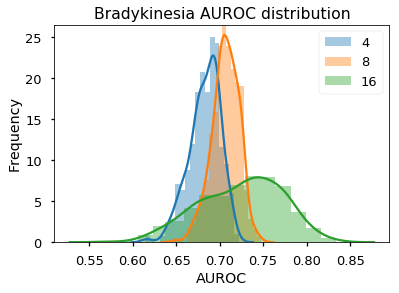

In [71]:
#load sim results
r = np.load(os.path.join(results_path,'brady_randomSubjs.npy')) #bradykinesia
r2=r.item()

for i in r2.keys():
    d = np.array(r2[i][0])
    d = d[~np.isnan(d)]
    ax=sns.distplot(d)
    ax.legend(r2.keys())
plt.xlabel('AUROC')
plt.ylabel('Frequency')
plt.title('Bradykinesia AUROC distribution')
plt.savefig('bradykinesia_results.png',bbox_inches='tight')#bradykinesia

##### boxplot

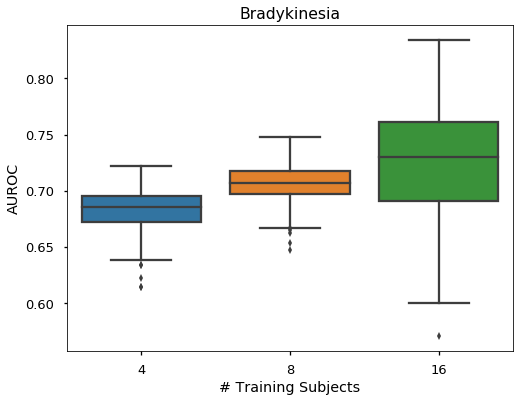

In [50]:
r = np.load(os.path.join(results_path,'brady_randomSubjs.npy')) #bradykinesia
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    subjects=[]; d=[];
#     for s in subjs:
#         inds = (np.squeeze(np.array(r2[n][1])) == s)
#         ds = np.mean(np.array(r2[n][0])[inds])
#         subjects.append(s)
#         d.append(ds)
    d=np.array(r2[n][0])
    auroc1 = pd.DataFrame(data=d,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)
    
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df)
# ax = sns.swarmplot(data=df,color="black")
plt.xlabel('# Training Subjects')
plt.ylabel('AUROC')
plt.title('Bradykinesia')
plt.savefig('Brady-AddSubjects.png',bbox_inches='tight')

##### baseline comparison

In [72]:
##DEPRECATED 5/21/2018, new structure does not allow subject-wise baseline comparison. Will update

#load sim results
# r = np.load(os.path.join(results_path,'brady_randomSubjs.npy')) #bradykinesia
# r2=r.item()

# df = pd.DataFrame()
# for n in r2.keys():
#     subjects=[]; d=[];
#     for s in subjs:
#         inds = (np.squeeze(np.array(r2[n][1])) == s)
#         ds = np.mean(np.array(r2[n][0])[inds])
#         subjects.append(s)
#         d.append(ds)
#     d = np.array(r2[n][0])
#     ax = sns.tsplot(d,ci='sd')
#     auroc1 = pd.DataFrame(data=d,columns=[int(n)])
#     df = pd.concat([df,auroc1],axis=1)

# df_new = 100*((df.T.iloc[1:] - df.T.iloc[0]) / df.T.iloc[0])
# df_new.plot(figsize=(8,6)); 
# ax = sns.tsplot(np.array(df))
# plt.legend(loc='center right',bbox_to_anchor=(1.2,0.5));
# plt.xlabel('# Training Subjects')
# plt.ylabel('% change in AUROC relative to 4 training subjects')
# plt.title('Bradykinesia')
# plt.savefig('Brady-Baseline-AddSubjects.png',bbox_inches='tight')

### Tremor

##### distribution plot

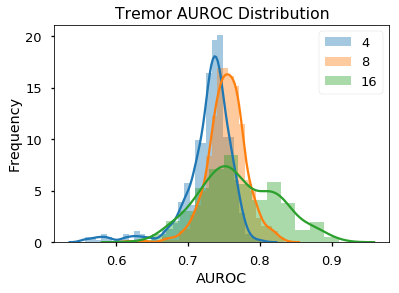

In [74]:
#load sim results
r = np.load(os.path.join(results_path,'tremor_randomSubjs.npy')) #tremor
r2=r.item()

for i in r2.keys():
    d = np.array(r2[i][0])
    d = d[~np.isnan(d)]
    ax=sns.distplot(d)
    ax.legend(r2.keys())
plt.xlabel('AUROC')
plt.ylabel('Frequency')
plt.title('Tremor AUROC Distribution')
plt.savefig('tremor_results.png',bbox_inches='tight')#bradykinesia

##### boxplot

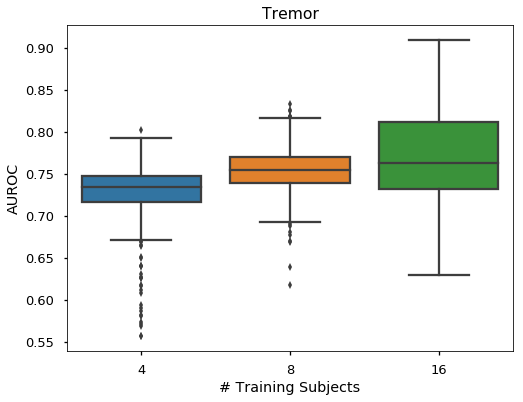

In [75]:
r = np.load(os.path.join(results_path,'tremor_randomSubjs.npy')) #tremor
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    subjects=[]; d=[];
#     for s in subjs:
#         inds = (np.squeeze(np.array(r2[n][1])) == s)
#         ds = np.mean(np.array(r2[n][0])[inds])
#         subjects.append(s)
#         d.append(ds)
    d=np.array(r2[n][0])
    auroc1 = pd.DataFrame(data=d,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)
    
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df)
# ax = sns.swarmplot(data=df,color="black")
plt.xlabel('# Training Subjects')
plt.ylabel('AUROC')
plt.title('Tremor')
plt.savefig('Tremor-AddSubjects.png',bbox_inches='tight')

##### baseline comparison

In [73]:
##DEPRECATED 5/21/2018, new structure does not allow subject-wise baseline comparison. Will update

# #load sim results
# r = np.load(os.path.join(results_path,'tremor_baselineCompare_randomSubjs.npy')) #bradykinesia
# r2=r.item()

# df = pd.DataFrame()
# for n in r2.keys():
#     subjects=[]; d=[];
#     for s in subjs:
#         inds = (np.squeeze(np.array(r2[n][1])) == s)
#         ds = np.mean(np.array(r2[n][0])[inds])
#         subjects.append(s)
#         d.append(ds)
#     auroc1 = pd.DataFrame(data=d,index=subjects,columns=[int(n)])
#     df = pd.concat([df,auroc1],axis=1)

# df_new = 100*((df.T.iloc[1:] - df.T.iloc[0]) / df.T.iloc[0])
# df_new.plot(figsize=(8,6));
# plt.legend(loc='center right',bbox_to_anchor=(1.2,0.5));
# plt.xlabel('# Training Subjects')
# plt.ylabel('% change in AUROC relative to 4 training subjects')
# plt.title('Tremor')
# plt.savefig('Tremor-Baseline-AddSubjects.png',bbox_inches='tight')

## Global Models - Training on Sessions 1, 1-6, and 1+6, Test on Day 2

In [201]:
visits_all=Data.Visit.unique()
visits_day1 = visits_all[visits_all != '4 Weeks']
tasks=Data.Task.unique()

#sample p visits at random for train and test on remaining
# ntrain = [1,2,3,4,5,6]
ntrain=[1,2,3,4,5]

# ntrain = [1,2,3]
# train = [['2 Weeks: Time 0'],
#          ['2 Weeks: Time 0','2 Weeks: Time 30','2 Weeks: Time 60','2 Weeks: Time 90','2 Weeks: Time 120','2 Weeks: Time 150'],
#          ['2 Weeks: Time 0','2 Weeks: Time 150']]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

#remove nan rows for current symptom
Data=Data[~Data[symptom].isnull()]

print(symptom)
results={}
for ng in ntrain:
    auc_all=[]; subj=[]; tasks_all=[];
    t1=time.time()
    for subs in subjs:
        data = Data[Data.Subject == subs]
        print(subs)
        for iteration in range(1):
    #         # select random test sessions out of all sessions, train on one remaining
    #         trainvisit = np.random.choice(visits_all,size=ng,replace=False) #sample subjects at random
    #         testvisit = np.random.choice(np.setxor1d(visits_all,trainvisit),size=1,replace=False)

            # select random test sessions out of all sessions, train on one remaining
    #         trainvisit = np.random.choice(visits_day1,size=ng,replace=False) #sample subjects at random

#             trainvisit = train[ng-1]
#             if ng == 7: #conditional for training on individual sessions + sessions 1 and 6
#                 trainvisit = ['2 Weeks: Time 0','2 Weeks: Time 150']
#             else:
#             trainvisit = [visits_day1[ng-1]] #individual sessions

            trainvisit = list(visits_day1[0:ng])#cumulative sessions
#             testvisit = ['4 Weeks']
            testvisit = ['2 Weeks: Time 150']

            dtrain = data[data.Visit.isin(trainvisit)]
            dtest = data[data.Visit.isin(testvisit)]
            Xtr = dtrain.iloc[:,7:].as_matrix()
            ytr = (dtrain[symptom]>0).values.astype(int)
            Xte = dtest.iloc[:,7:].as_matrix()
            yte = (dtest[symptom]>0).values.astype(int)
            ytask = dtest[dtest[symptom]>0].Task
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            if np.size(Xte) == 0:
#                 auc_all.append(np.nan)
#                 subj.append(subs)
#                 tasks_all.append(testvisit)
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan

            auc_all.append(auroc)
            subj.append(subs)
            tasks_all.append(testvisit)

            if iteration%50==0:
                print('TrainVisit=%s,Test=%s,Iter=%d, AUROC=%.3f'%(trainvisit,testvisit,iteration,auroc))

        results.update({ng:[auc_all,subj,tasks_all]}) #save auc for all runs for each group
        print('elapsed %.3f min'%((time.time()-t1)/60))

np.save(os.path.join(results_path,'brady_TestDay1_randomVisits.npy'),results)

Bradykinesia
1004
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.592
elapsed 0.001 min
1016
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.664
elapsed 0.002 min
1018
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.688
elapsed 0.003 min
1019
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.891
elapsed 0.005 min
1024
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.524
elapsed 0.006 min
1029
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.470
elapsed 0.008 min
1030
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.803
elapsed 0.009 min
1032
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.556
elapsed 0.012 min
1038
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.799
elapsed 0.015 min
1044
TrainVisit=['2 Weeks: Time 0'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0

TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.911
elapsed 0.035 min
1038
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.876
elapsed 0.040 min
1044
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.903
elapsed 0.043 min
1046
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.954
elapsed 0.046 min
1047
only 1 class in test data - cannot compute roc curve
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=nan
elapsed 0.049 min
1049
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90'],Test=['2 Weeks: Time 150'],Iter=0, AUROC=0.718
elapse

### Bradykinesia

##### confidence plot

C:\Users\andre\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


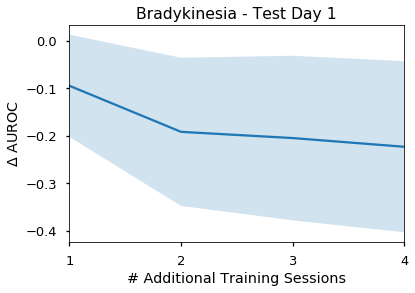

In [209]:
#load sim results
r = np.load(os.path.join(results_path,'brady_TestDay1_randomVisits.npy'))
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    if n == 1:
        continue
    sub = np.array(r2[n][1])
    d_auroc = (np.array(r2[1][0]) - np.array(r2[n][0]))
    auroc1 = pd.DataFrame(data=[d_auroc,sub,int(n-1)*np.ones(np.shape(sub))],index=['Dauroc','subID','group'])
    df = pd.concat([df,auroc1.T],axis=0)

df_new = df.reset_index(drop=True)
df_new = df_new.dropna(axis=0)

ax = sns.tsplot(df_new,time='group',unit='subID',value='Dauroc',ci='sd');
plt.xlabel('# Additional Training Sessions');
plt.ylabel(r'$\Delta$ AUROC');
plt.xticks(np.arange(1,5),['1','2','3','4']);
plt.title('Bradykinesia - Test Day 1');
plt.savefig('brady_addVisits_day1.png',bbox_inches='tight')

##### confidence plot

C:\Users\andre\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


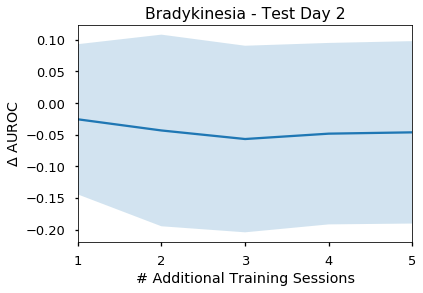

In [205]:
#load sim results
r = np.load(os.path.join(results_path,'brady_TestDay2_randomVisits.npy'))
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    if n == 1:
        continue
    sub = np.array(r2[n][1])
    d_auroc = (np.array(r2[1][0]) - np.array(r2[n][0]))
    auroc1 = pd.DataFrame(data=[d_auroc,sub,int(n-1)*np.ones(np.shape(sub))],index=['Dauroc','subID','group'])
    df = pd.concat([df,auroc1.T],axis=0)

df_new = df.reset_index(drop=True)
df_new = df_new.dropna(axis=0)

ax = sns.tsplot(df_new,time='group',unit='subID',value='Dauroc',ci='sd');
plt.xlabel('# Additional Training Sessions');
plt.ylabel(r'$\Delta$ AUROC');
plt.xticks(np.arange(1,6),['1','2','3','4','5']);
plt.title('Bradykinesia - Test Day 2');
plt.savefig('brady_addVisits_day2.png',bbox_inches='tight')

##### distribution

Text(0.5,1,'random visit set')

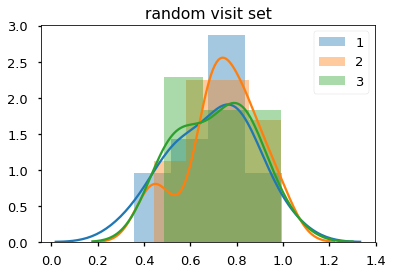

In [78]:
#load sim results
r = np.load(os.path.join(results_path,'brady_3sessions_subjsims_randomVisits.npy'))
r2=r.item()

for i in r2.keys():
    sc = np.array(r2[i][0])
    sc = sc[~np.isnan(sc)]
    ax=sns.distplot(sc)
    ax.legend(r2.keys())
plt.title('random visit set')
# plt.savefig('brady_3sessions_testRandomVisitsResults.png',bbox_inches='tight')

##### boxplot

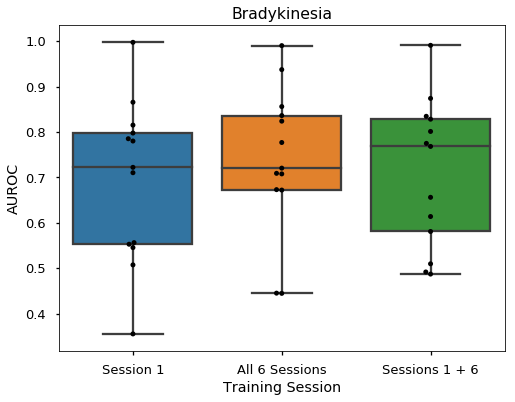

In [79]:
#load sim results
r = np.load(os.path.join(results_path,'brady_3sessions_subjsims_randomVisits.npy'))
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    sub = np.array(r2[n][1])
    auroc1 = pd.DataFrame(data=np.array(r2[n][0]),index=sub,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)
    
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df,color="black")
ax.set(xticklabels=['Session 1','All 6 Sessions','Sessions 1 + 6'])
plt.xlabel('Training Session')
plt.ylabel('AUROC')
plt.title('Bradykinesia')
plt.savefig('Brady-3sessions-Results.png')

### Tremor

##### confidence plot

C:\Users\andre\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


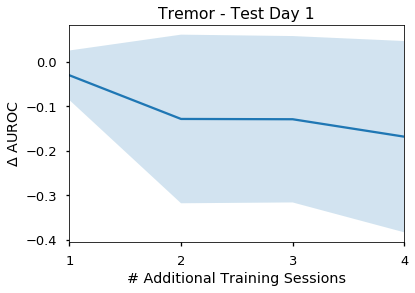

In [196]:
#load sim results
r = np.load(os.path.join(results_path,'tremor_TestDay1_randomVisits.npy'))
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    if n == 1:
        continue
    sub = np.array(r2[n][1])
    d_auroc = (np.array(r2[1][0]) - np.array(r2[n][0]))
    auroc1 = pd.DataFrame(data=[d_auroc,sub,int(n-1)*np.ones(np.shape(sub))],index=['Dauroc','subID','group'])
    df = pd.concat([df,auroc1.T],axis=0)

df_new = df.reset_index(drop=True)
df_new = df_new.dropna(axis=0)

ax = sns.tsplot(df_new,time='group',unit='subID',value='Dauroc',ci='sd');
plt.xlabel('# Additional Training Sessions');
plt.ylabel(r'$\Delta$ AUROC');
plt.xticks(np.arange(1,5),['1','2','3','4']);
plt.title('Tremor - Test Day 1');
plt.savefig('tremor_addVisits_day1.png',bbox_inches='tight')

##### confidence plot

C:\Users\andre\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


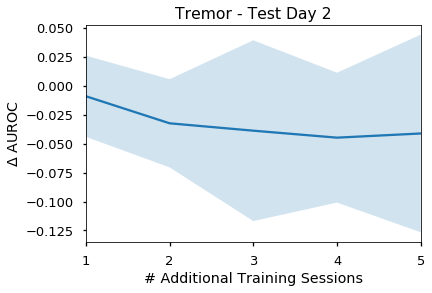

In [197]:
#load sim results
r = np.load(os.path.join(results_path,'tremor_TestDay2_randomVisits.npy'))
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    if n == 1:
        continue
    sub = np.array(r2[n][1])
    d_auroc = (np.array(r2[1][0]) - np.array(r2[n][0]))
    auroc1 = pd.DataFrame(data=[d_auroc,sub,int(n-1)*np.ones(np.shape(sub))],index=['Dauroc','subID','group'])
    df = pd.concat([df,auroc1.T],axis=0)

df_new = df.reset_index(drop=True)
df_new = df_new.dropna(axis=0)

ax = sns.tsplot(df_new,time='group',unit='subID',value='Dauroc',ci='sd');
plt.xlabel('# Additional Training Sessions');
plt.ylabel(r'$\Delta$ AUROC');
plt.xticks(np.arange(1,6),['1','2','3','4','5']);
plt.title('Tremor - Test Day 2');
plt.savefig('tremor_addVisits_day2.png',bbox_inches='tight')

##### distribution

Text(0.5,1,'random visit set')

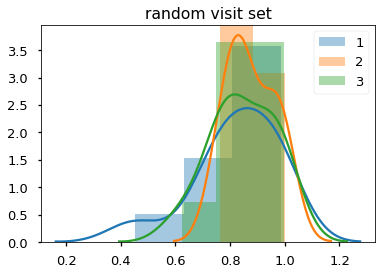

In [84]:
#load sim results
r = np.load(os.path.join(results_path,'tremor_3sessions_subjsims_randomVisits.npy'))
r2=r.item()

for i in r2.keys():
    sc = np.array(r2[i][0])
    sc = sc[~np.isnan(sc)]
    ax=sns.distplot(sc)
    ax.legend(r2.keys())
plt.title('random visit set')
# plt.savefig('tremor_3sessions_testRandomVisitsResults.png',bbox_inches='tight')

##### boxplot

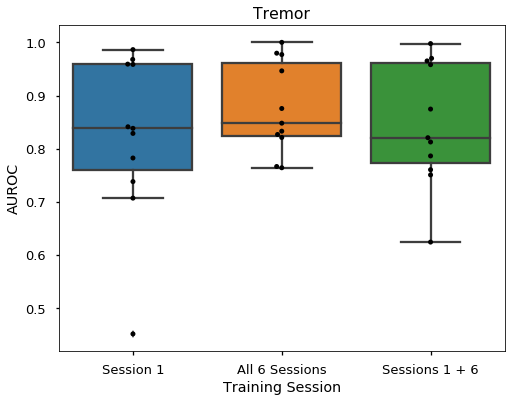

In [85]:
#load sim results
r = np.load(os.path.join(results_path,'tremor_3sessions_subjsims_randomVisits.npy'))
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    sub = np.array(r2[n][1])
    auroc1 = pd.DataFrame(data=np.array(r2[n][0]),index=sub,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)
    
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df,color="black")
ax.set(xticklabels=['Session 1','All 6 Sessions','Sessions 1 + 6'])
plt.xlabel('Training Session')
plt.ylabel('AUROC')
plt.title('Tremor')
plt.savefig('Tremor-3sessions-Results.png')

## Global Models - Train on Cumulative Sessions

In [ ]:
visits_all=Data.Visit.unique()
visits_day1 = visits_all[visits_all != '4 Weeks']
tasks=Data.Task.unique()

#sample p visits at random for train and test on remaining
ntrain = [1,2,3,4,5,6,7]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

#remove nan rows for current symptom
Data=Data[~Data[symptom].isnull()]

print(symptom)
results={}
for ng in ntrain:
    auc_all=[]; subj=[]; tasks_all=[];
    t1=time.time()
    for subs in subjs:
        data = Data[Data.Subject == subs]
        print(subs)
        for iteration in range(1):
    #         # select random test sessions out of all sessions, train on one remaining
    #         trainvisit = np.random.choice(visits_all,size=ng,replace=False) #sample subjects at random
    #         testvisit = np.random.choice(np.setxor1d(visits_all,trainvisit),size=1,replace=False)

            # select random test sessions out of all sessions, train on one remaining
    #         trainvisit = np.random.choice(visits_day1,size=ng,replace=False) #sample subjects at random

            trainvisit = train[ng-1]
            if ng == 7: #conditional for training on individual sessions + sessions 1 and 6
                trainvisit = ['2 Weeks: Time 0','2 Weeks: Time 150']
            else:
#                 trainvisit = [visits_day1[ng-1]] #individual sessions
                trainvisit = list(visits_day1[0:ng])#cumulative sessions
                
            testvisit = ['4 Weeks']

            dtrain = data[data.Visit.isin(trainvisit)]
            dtest = data[data.Visit.isin(testvisit)]
            Xtr = dtrain.iloc[:,7:].as_matrix()
            ytr = (dtrain[symptom]>0).values.astype(int)
            Xte = dtest.iloc[:,7:].as_matrix()
            yte = (dtest[symptom]>0).values.astype(int)
            ytask = dtest[dtest[symptom]>0].Task
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            if np.size(Xte) == 0:
#                 auc_all.append(np.nan)
#                 subj.append(subs)
#                 tasks_all.append(testvisit)
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan

            auc_all.append(auroc)
            subj.append(subs)
            tasks_all.append(testvisit)

            if iteration%50==0:
                print('TrainVisit=%s,Test=%s,Iter=%d, AUROC=%.3f'%(trainvisit,testvisit,iteration,auroc))

        results.update({ng:[auc_all,subj,tasks_all]}) #save auc for all runs for each group
        print('elapsed %.3f min'%((time.time()-t1)/60))

np.save(os.path.join(results_path,'brady_3sessions_subjsims_randomVisits.npy',results))

In [ ]:
#load sim results
r = np.load('brady_cumulative_subjsims_randomVisits.npy')
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    sub = np.array(r2[n][1])
    auroc1 = pd.DataFrame(data=np.array(r2[n][0]),index=sub,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)

df.T.plot(figsize=(8,6))
plt.legend(loc='center right',bbox_to_anchor=(1.2,0.5));
plt.title('Bradykinesia Day 2 AUROC per additional cumulative session');
plt.xlabel('Training Session');
plt.ylabel('Day 2 AUROC');
plt.savefig('brady_cumulative_auroc_perSession.png',bbox_inches='tight')

In [ ]:
#load sim results
r = np.load('tremor_cumulative_subjsims_randomVisits.npy')
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    sub = np.array(r2[n][1])
    auroc1 = pd.DataFrame(data=np.array(r2[n][0]),index=sub,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)

df.T.plot(figsize=(8,6))
plt.legend(loc='center right',bbox_to_anchor=(1.2,0.5));
plt.title('Tremor Day 2 AUROC per additional cumulative session');
plt.xlabel('Training Session');
plt.ylabel('Day 2 AUROC');
plt.savefig('tremor_cumulative_auroc_perSession.png',bbox_inches='tight')

In [ ]:
# for sub in Data.Task.unique():
#     plt.figure(figsize=(8,6));
#     for n in r2.keys():
#         all_results = np.expand_dims(r2[n][0],1);
# #         subject_list = np.array(r2[n][1]);
#         task_list = r2[n][2];
        
#         inds = [i for i, s in enumerate(task_list) if s == sub]
        
#         d = all_results[inds]
        
#         ax=sns.distplot(d);
#         ax.legend(r2.keys());
#     plt.title('Task %s results'%sub);
#     plt.savefig('Task%s.png'%sub, bbox_inches='tight');

In [ ]:
# for i in results.keys():
#     ax=sns.distplot(results[i])
#     ax.legend(results.keys())
# plt.title('random test features set')
# plt.savefig('testRandomResults.png',bbox_inches='tight')

## Personal Models - Train on One Session Test on Rest

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
print('Training on 1 session, testing on remainder...')
ds = Data.loc[Data.Visit != '4 Weeks']
ds2 = Data.loc[Data.Visit == '4 Weeks'] #(Day 2)

#train/test on Day 1
indp = (ds[symptom]>0).values
y = indp.astype(int) #target 
X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data

models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = le.fit_transform(ds.Visit)
# if len(np.unique(groups))<2:
#     continue

#train/test on day 1 (LOin)
res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
#     res.index = res.index+s
res_all=pd.concat((res_all,res))
res_visit_all.append(res_group)
# day1_1 = res_all.auroc #mean auc per subject across 
day1_1 = res_group['Random Forest']['auroc']

#test on day 2    
if ds2.empty is False:
    print('Testing on day 2')
    clf = models[0][0]
    X2 = ds2.iloc[:,7:].as_matrix()
    yte = (ds2[symptom]>0).values.astype(int) 
    yscore = clf.predict_proba(X2)
    yscore = yscore[:,1]
    if len(np.unique(yte))>1:
        auroc = roc_auc_score(yte,yscore)
    else:
        print('only 1 class in test data - cannot compute roc curve')
        auroc = np.nan
    auroc2_1.append(auroc) #auc from each subject when tested on day 2

plt.bar(range(7),list(np.squeeze([day1_1 + auroc2_1])));
plt.title('Training on 1 session from Day 1');
plt.xlabel('Visit Left In');
plt.ylabel('AUROC');
plt.savefig('LOVI-Global.png',bbox_inches='tight')

    


## Personal Models - Train on 5 visits, test on remaining

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
print('Training on 5 visits...')
ds = Data.loc[Data.Visit != '4 Weeks']
ds2 = Data.loc[Data.Visit == '4 Weeks'] #(Day 2)

#train/test on Day 1
indp = (ds[symptom]>0).values
y = indp.astype(int) #target 
X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data

models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = le.fit_transform(ds.Visit)
# if len(np.unique(groups))<2:
#     continue

#train/test on day 1 (LOin)
res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
# res.index = res.index+s
res_all=pd.concat((res_all,res))
res_visit_all.append(res_group)
day1_5 = res_group['Random Forest']['auroc'] #mean auc per subject across 

#test on day 2    
if ds2.empty is False:
    print('Testing on day 2')
    clf = models[0][0]
    X2 = ds2.iloc[:,7:].as_matrix()
    yte = (ds2[symptom]>0).values.astype(int) 
    yscore = clf.predict_proba(X2)
    yscore = yscore[:,1]
    if len(np.unique(yte))>1:
        auroc = roc_auc_score(yte,yscore)
    else:
        print('only 1 class in test data - cannot compute roc curve')
        auroc = np.nan
    auroc2_5.append(auroc) #auc from each subject when tested on day 2

plt.bar(range(7),list(np.squeeze([day1_5 + auroc2_1])));
plt.xlabel('Visit Left Out');
plt.ylabel('AUROC');
plt.title('Train on 5 Sessions from Day 1')
plt.savefig('LOVO-Global.png',bbox_inches='tight')

In [ ]:
def LPGOCV(X,y,groups,models,ng):

    subj = LeavePGroupsOut(n_groups=ng) 
    results = pd.DataFrame(data=None,columns=['model','f1','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres

# Subgroup of tasks (4)

In [ ]:
filename = 'Features_AllLocs_HP+LP_GyroLP.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)

In [ ]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

Dataorig = Data.copy()
#remove nan symptoms
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]

In [ ]:
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]